# Q1 Gillespie's Direct Algorithm and Stochastic Hallmarks

Investigate
1. Variability
2. Negative co-variances
3. Increased transients
4. Stochastic resonance
5. Extinctions

In [30]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from random import random

In [53]:
# def dX(N, X, Y, beta, gamma, birth_rate):
#     changeX = 
#     return changeX

# def dY(N, X, Y, beta, gamma, birth_rate):
#     changeY = 
#     return changeY

# def dZ(N, Y, Z, gamma, birth_rate):
#     changeZ = 
#     return changeZ

def determinsteSIR(previousState, t, beta, gamma, birth_ate):
    N = np.sum(previousState)
    state = np.empty(3)
    X,Y,Z = previousState
    state[0] = birth_rate - X/N*birth_rate - X*Y/N*beta
    state[1] = X*Y/N*beta   - Y/N*birth_rate - Y/N*gamma 
    state[2] = Y/N*gamma    - Z/N*birth_rate
    return state
    

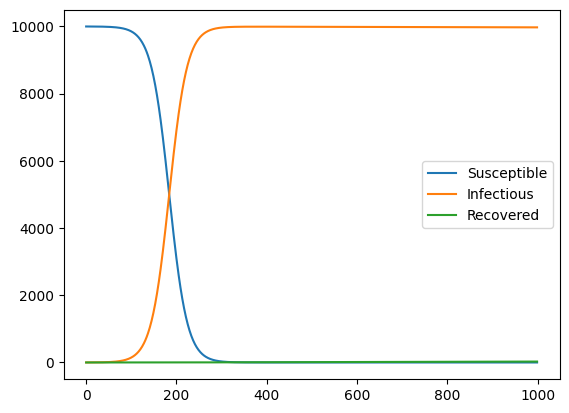

In [58]:
XYZ = [10000, 1, 0]
t = np.linspace(0,100,1000)
beta = 1/2
gamma = 1/3
birth_rate = 1/200

solved = odeint(determinsteSIR, XYZ, t, (beta, gamma, birth_rate))
plt.plot(solved[:, 0], label = "Susceptible")
plt.plot(solved[:, 1], label = "Infectious")
plt.plot(solved[:, 2], label = "Recovered")
plt.legend(loc="best")

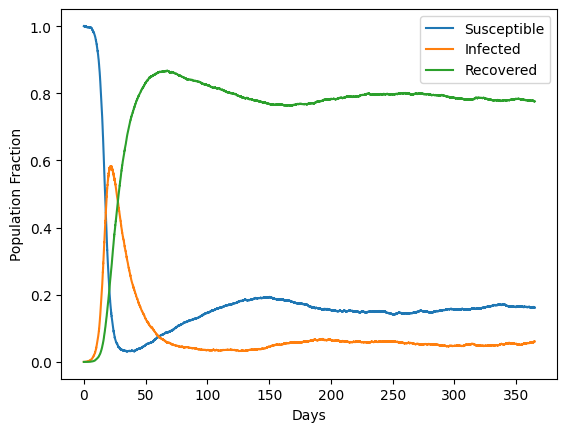

In [111]:
beta = 1/2
gamma = 1/14
mu = 1/200
XYZ = np.array((10000, 1, 0))
tend = 365
N = XYZ[0] + XYZ[1] + XYZ[2]

def stoch_sir(XYZ):
	current_t = 0
	ts = 0
	T = [0]
	S = [XYZ[0]]
	I = [XYZ[1]]
	R = [XYZ[2]]
 
	while T[current_t] < tend:
		T.append(T[-1] + ts)
		S.append(XYZ[0])
		I.append(XYZ[1])
		R.append(XYZ[2])

		update = np.zeros((6,3))
		event_rates = ([(beta * XYZ[0] * XYZ[1])/N, gamma * XYZ[1], 
                  mu * N,  mu * XYZ[0], mu * XYZ[1], mu * XYZ[2]])

		update[0,0] -= 1
		update[0,1] += 1
		update[1,1] -= 1
		update[1,2] += 1
		update[2,0] += 1
		update[3,0] -= 1
		update[4,1] -= 1
		update[5,2] -= 1
 
		rand_1 = random()
		rand_2 = random()
		ts = -np.log(rand_1)/(np.sum(event_rates))

		p = rand_2 * np.sum(event_rates)
		event_index = min(np.nonzero(np.ravel(np.cumsum(event_rates) >= p))[0])
	
		for i in range(3): 
			XYZ[i] = XYZ[i] + update[event_index,i]
  
		current_t = current_t + 1
    
	return [T, S, I, R]

[T, S, I, R] = stoch_sir(XYZ)

data_T = np.array(T)
data_S = np.array(S)/10000
data_I = np.array(I)/10000
data_R = np.array(R)/10000

plt.plot(data_T, data_S, data_T, data_I, data_T, data_R)
plt.xlabel("Days")
plt.ylabel("Population Fraction")
plt.legend(["Susceptible", "Infected", "Recovered"])
plt.show()


## Investigate Simultion variability and Negative Co-variance

> Investigate how varying the model parameters changes the behavior of the stochatic dynamics. How do the related to the variance between runs and the negative covariance between $S$ and $I$.

> Compare the mean of the stochatic models to their deterministic counter parts

## Stochatic Resonance and Increase Transients
> Show how the stochatic models can induce stochatic resonance aroudn the equilibiruim and how that resonance relates to the paramters.

> Show some example of increased transients away from the deterministic equilibiruim. Which parameters lead to the largest transient?

## Extinction events and Critical Community Size
> Design an experiment that shows the effect of varying $R_0$ on the extinction process. *Keep in mind that int he closed system randomness will always eventually lead to extinction*. 

> Look at how the extinction events are impacted by the population size. Find a way to show how the two parameter $R_0$ and $N$ ineract to imact the extinction process.